In [2]:
# Fill in your name using the given format
your_name = "Nien, Ting Yu"

In [3]:
# For use in colab
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    !pip install openml --quiet

# Assignment 1
We will study classifiers on the [Kuzushiji dataset](https://www.openml.org/d/41982).
As you can [read in the paper](https://arxiv.org/abs/1812.01718), Kuzushiji is a handwritten 
Japanese script that was used for thousands of years, but most Japanese natives cannot read
it anymore. We'll try to use machine learning to recognize the characters, and translate them to
modern Japanese (Hiragana) characters.

The dataset that we will use contains scanned 28-by-28 pixel images of such handwritten characters. Actually, only 10 of those characters.

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
import math
import tqdm
%matplotlib inline

# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.0.2"):
    print("scikit-learn is outdated: {}. Please update now! pip install -U scikit-learn".format(sklearn_version))
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [5]:
# Download Kuzushiji-MNIST data. Takes a while the first time.
# You may receive a warning about data compression but you can ignore that.
# Don't overwrite the X and y variables anywhere in this notebook. 
# Seriously, don't.
data = openml.datasets.get_dataset(41982)
X, y, _, _ = data.get_data(target=data.default_target_attribute);
X = X/255 # Simple scaling 

# These are the names of the modern characters (our 10 classes)
data_classes = {0:"o", 1: "ki", 2: "su", 3: "tsu", 4: "na", 5: "ha", 
                6: "ma", 7: "ya", 8: "re", 9: "wo"}

In [140]:
# Plotting helper functions. Don't edit these.
%matplotlib inline
from IPython import display

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

# Plots data instances as 28x28 images
def plot_examples(images, labels, row_length=5, title=""):
    """ Renders a set of images
    images -- an array of 28x28 images as 1D vectors
    labels -- the corresponding labels for each image
    row_length -- how many images should be shown per line
    title -- a title for the produced figure
    """
    nr_rows = math.floor(len(images) / row_length)
    if (len(images) % row_length) > 0:
        nr_rows += 1
    fig, axes = plt.subplots(nr_rows, row_length, figsize=(1.5 * row_length, 1.5 * nr_rows))
    for i, n in enumerate(images):
        if len(images) > row_length:
            axes[math.floor(i/row_length)][i%row_length].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            if labels is not None:
              axes[math.floor(i/row_length)][i%row_length].set_xlabel(data_classes[int(labels[i])])
            axes[math.floor(i/row_length)][i%row_length].set_xticks(())
            axes[math.floor(i/row_length)][i%row_length].set_yticks(())

        else:
            axes[i].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            if labels is not None:
              axes[i].set_xlabel(data_classes[int(labels[i])])
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    fig.suptitle(title);

# Plots the coefficients of the given model as 28x28 heatmaps. 
def plot_coefficients(coef, name):
    """ Renders a 28x28 heatmap of the model's trained coefficients.
    Keyword arguments:
    coef -- the model coefficients
    name -- a title for the produced figure
    """
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    fig.suptitle(name)
    ax.imshow(coef.reshape(28,28))
    ax.set_xticks(()), ax.set_yticks(())

### Peeking at the data
If we plot the characters, we see that there is quite some variation. The same
character can be written in a number of different ways.

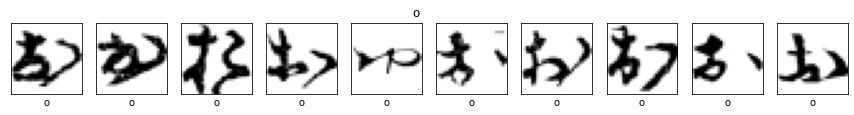

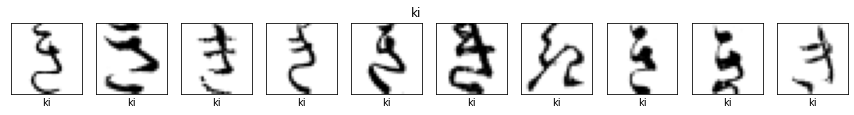

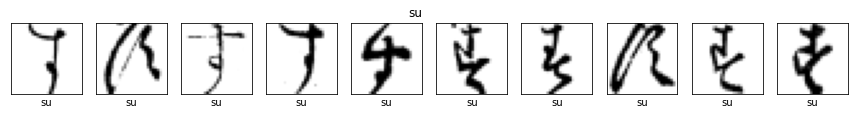

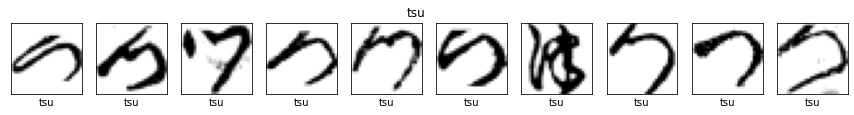

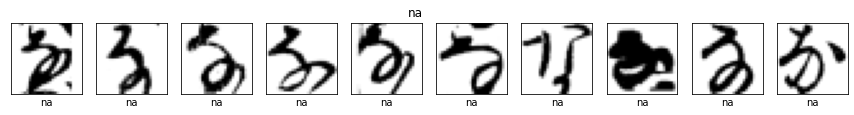

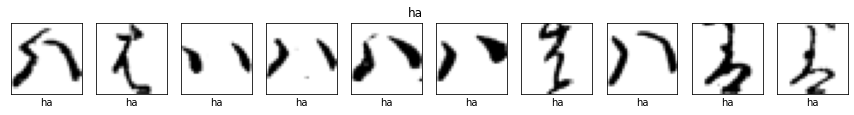

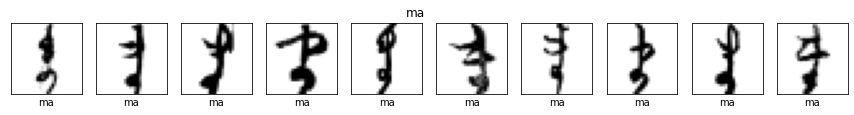

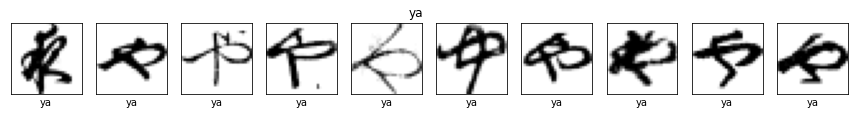

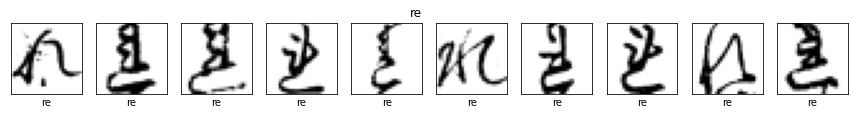

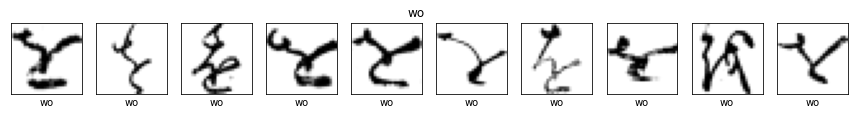

In [141]:
# Gets indices of examples with the given class
def y_class(c):
    return y[y == str(c)].index.values.tolist()[10:20]

for i in range(10):
    plot_examples(X.to_numpy()[y_class(i)], y.to_numpy()[y_class(i)], 
                  row_length=10, title=data_classes[i])

### Question 1.1: Cross-validate (1 point)
Implement a method `evaluate_LR` that evaluates a Logistic Regression model for a given regularization constant (C) and returns the train and test score of a 5-fold stratified cross-validation using the accuracy metric. Note: we know that Logistic Regression is not the best technique for image data :). We'll use other techniques in future assignments.

In [8]:
# Implement
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

def evaluate_LR(X, y, C):
    """ Evaluate an Logistic Regression with 5-fold cross-validation on the provided (X, y) data. 
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    C -- the value for the regularization hyperparameter
    
    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    #max_iter=100
    scores = cross_validate(LogisticRegression(C=C), X, y, cv=5, return_train_score= True, n_jobs=-1)
    mean_train_test = {"train": np.mean(scores["train_score"]), "test": np.mean(scores["test_score"])}
    return mean_train_test

### Question 1.2: Tune (1 points)

Implement a method `plot_curve` that plots the results of `evaluate_LR` on a 25% stratified subsample of the Kuzushiji MNIST dataset for C values ranging from 1e-8 to 1e3 (on a log scale, at least 12 values). Use `random_state=0`. You can use the plotting function `plot_live` defined above (carefully read what it does), and add any helper functions you like. Note:  To be clear, you need to pass only 25% of the data to `evaluate_LR`. Using a 25% subsample won't give you optimal performance, but this is meant to make the assignment more doable.

/Users/yabee/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yabee/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

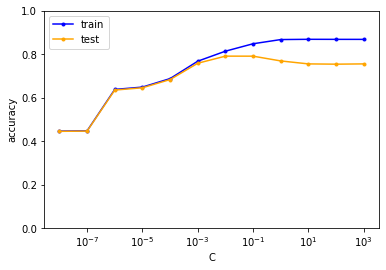

In [9]:
# Implement. Do not change the name or signature of this function.
from sklearn.model_selection import train_test_split

def plot_curve(X,y):
    """ Plots the train and test accuracy of logistic regression on a 25% 
    subsample of the given data for different amounts of regularization.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: a plot as described above, with C on the x-axis and accuracy on 
    the y-axis. 
    """
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X, y, stratify=y, train_size=0.25, random_state=0)
    C_val = np.logspace(-8, 3,num=12)
    evaluator_list = [evaluate_LR(X_sub_train, y_sub_train, c) for c in C_val]
    train_evaluator_list = [x['train'] for x in evaluator_list]
    test_evaluator_list = [x['test'] for x in evaluator_list]
    plt.plot(C_val, train_evaluator_list, color='blue', label='train', marker='.')
    plt.plot(C_val, test_evaluator_list, color='orange', label='test', marker='.')
    plt.ylabel('accuracy')
    plt.xlabel('C')
    plt.xscale('log')
    plt.ylim(0,1)
    plt.legend(loc = "best", fontsize=10)
    plt.show()
    pass
plot_curve(X,y)

### Question 1.3: Interpretation (1 point)
Interpret the graph. At C=1e-6, is the model underfitting, overfitting, or neither? What about the model trained with C=100? Below are a number of possible interpretations. Enter the correct letter in value `q_1.3` in the code.

- 'A': Underfitting at C=1e-6, overfitting at C=100.  
- 'B': Overfitting at C=1e-6, underfitting at C=100.  
- 'C': Neither underfitting nor overfitting at C=1e-6, overfitting at C=100.
- 'D': Neither underfitting nor overfitting at C=1e-6, underfitting at C=100.
- 'E': Overfitting at C=1e-6, neither underfitting nor overfitting at C=100.
- 'F': Underfitting at C=1e-6, neither underfitting nor overfitting at C=100.
- 'G': Neither underfitting nor overfitting at both values for C.
- 'H': No answer

In [10]:
# Fill in the correct answer. Don't change the name of the variable
q_1_3 = 'C'

### Question 2.1: Model inspection (2 points)
Implement a function `plot_tsu_coefficients` that plots a heatmap of the coefficients of three models (after training), one trained with C=10e-6, one with C=0.01, and one with C=10. You can use the `plot_coefficients` helper function (see above). Only plot the coefficients of the model that separates the character `tsu` from the other characters. You can assume that a one-vs-rest-like approach is used for multi-class problems, hence the n-th set of coefficients belong to the model that separates the n-th class. You should get three plots in total.

First split the data in a default stratified train-test split. Train the models on the training data and score the accuracy on the test data. Add the C-value and accuracy to the title of the plots. 

Note: You may get convergence warnings. If so, just increase the number of optimization iterations (`max_iter`). Especially models with high C values can take longer to converge (can you guess why?). You can also choose to ignore these warnings since they won't affect the results much.  
Note 2: Scikit-learn actually uses [a more sophisticated approach](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html#sphx-glr-auto-examples-linear-model-plot-logistic-multinomial-py) here than simple one-vs-all. It uses the fact that Logistic Regression predicts probabilities, and hence the probabilities of each class are taken into account (in a softmax function). It will still produce one model per class.

/Users/yabee/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yabee/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

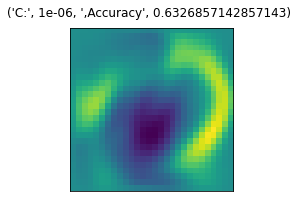

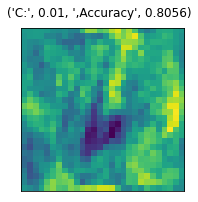

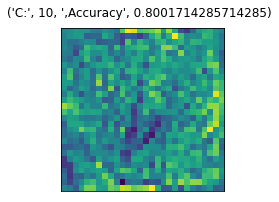

In [155]:
# Implement. Do not change the name or signature of this function.


def Inspection_LR(X, y, c_iter):
    multi_class='multinomial'
    clf = LogisticRegression(C=c_iter, max_iter=100, multi_class = multi_class).fit(X,y)
    # acc = clf.score(Xs_test,ys_test)
    # return clf.coef_[3], acc
    return clf
    pass

def plot_tsu_coefficients(X,y):
    """ Plots 28x28 heatmaps showing the coefficients of three Logistic 
    Regression models, each with different amounts of regularization values.
    X -- the data for training and testing
    y -- the correct labels
    
    Returns: 3 plots, as described above.
    """
    Xs, Xs_test, ys,ys_test = train_test_split(X, y, stratify=y, random_state=0)
    C_classification = [1e-6, 0.01, 10]
    for c_iter in C_classification:
        models = Inspection_LR(Xs,ys, c_iter)
        acc = models.score(Xs_test, ys_test)
        name='C:', c_iter, ',Accuracy', acc
        plot_coefficients(models.coef_[3], name)
    pass
plot_tsu_coefficients(X,y)

## Question 2.2: Interpretation (1 points)
Interpret the results. Which model works best? What is each of the models paying attention to when making predictions? Does that make sense - i.e. did the model learn something useful about the character *tsu*? Compare this to the results of question 1.2 and 1.3: does that help explain the results? Please formulate your answer in the string variable below. Keep your answer within 500 characters.

In [12]:
q_2_2 = """
        Your answer 
        """

if len(q_2_2.strip()) > 500:
  print("Answer is {} characters long. Please shorten it to 500 characters.".format(len(q_2_2.strip())))

## Question 3.1: Mistake analysis (2 point)
Let's focus more on the character 'tsu' and the behavior of the model with C=1e-6.

First split the data again in a default stratified train-test split. Train the models on the training data and produce the predictions on the test data.

Next, take the test examples which actually represent 'tsu'. From these, identify the ones which are predicted correctly and which ones are not.

Finally, plot these examples using the `plot_examples` function, together with the predicted class (character). Create two plots (e.g. by calling `plot_examples` twice): one with 20 examples of 'tsu' characters which are predicted correctly, and a second with 20 examples of 'tsu' characters which are predicted incorrectly by this model. Indicate in the figure `title` which 'tsu' characters are correct and which ones are misclassified.

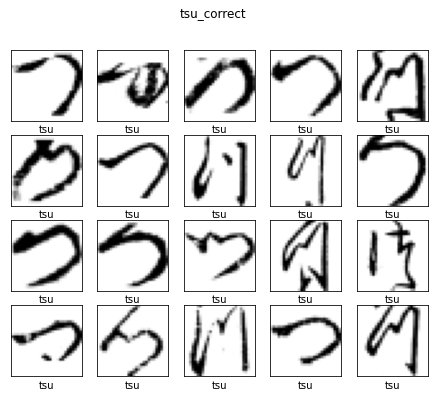

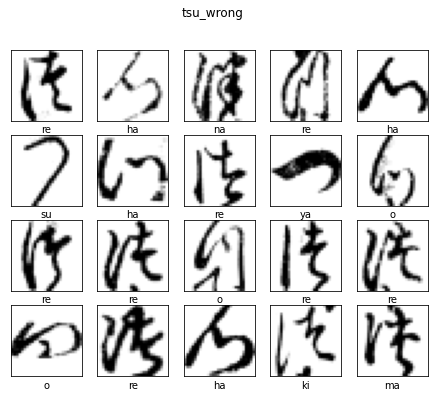

In [371]:
# Implement. Do not change the name or signature of this function.

def plot_mistakes(X,y):
    """ Plots two sets of images. The first set shows 20 examples of characters
    predicted correctly by a Logistic Regression classifier with C=1e-6. The 
    second set shows 20 examples of misclassifications. 
    X -- the data for training and testing
    y -- the correct labels
    Returns: 2 sets of plots, as described above.
    """
    X_train, X_test, y_train,y_test = train_test_split(X, y, stratify=y, random_state=0)
    # print(X_test.head(1))
    multi_class='multinomial'
    clf = LogisticRegression(C=1e-6, max_iter=100, multi_class = multi_class).fit(X_train,y_train)

#   vector of class labels for each sample
    y_pred = clf.predict(X_test)
    
#   test data for real tsu
    X_real_tsu = X_test[y_test.values == '3']  
    
#   y_test for real tsu with data number and feature data > series
    y_real_tsu = y_test[y_test.values == '3']
    
#   y_test for real tsu with only index
    y_real_tsu_index = np.nonzero(y_test.values == '3')[0]
    
#   y_pred with the prediction of true samples > array
    y_real_tsu_pred = y_pred[y_real_tsu_index]

#   to test the prediction right or wrong
#   the index of x_test
    correctclassified = np.nonzero(y_real_tsu_pred == list(y_real_tsu))[0]
    missclassified = np.nonzero(y_real_tsu_pred != list(y_real_tsu))[0]

#  pick the first 20 index
    correct_example = correctclassified[:20]
    wrong_example = missclassified[:20]
    plot_examples(X_real_tsu.values[correct_example], labels=y_real_tsu_pred[correct_example], title="tsu_correct")
    plot_examples(X_real_tsu.values[wrong_example], labels=y_real_tsu_pred[wrong_example], title="tsu_wrong")
    pass
plot_mistakes(X,y)

## Question 3.2: Interpretation (1 point)
Interpret the results. Can you explain which kinds of 'tsu' characters are predicted correctly and which ones are not? Compare this with what you observed in question 2.1 and 2.2. What does that tell you about the model? Please formulate your answer in the string variable below. Keep your answer within 500 characters.

In [13]:
q_3_2 = """
        Your answer 
        """

if len(q_3_2.strip()) > 500:
  print("Answer is {} characters long. Please shorten it to 500 characters.".format(len(q_3_2.strip())))

## Question 4 (1 point)

Archeologists found an ancient text in the mountain cave temples of Shodoshima, which is partially decifered into the following sentence:
***
**<word 1>** LOOKS BEAUTIFUL OVER THE **<word 2>**
***

They need your help to uncover the meaning of the missing characters and expand our knowledge on early Japanese literature. 

They sent us pictures of the missing characters in the form of 28x28 numpy arrays (because why not). This file is included. If not, the code below loads it into the notebook.

Both words consist of two characters as shown below. The first two characters form the first word and the last two form the second.

In [14]:
# Uncomment this code if you don't have the mystery_characters.npy file.
# !pip install gdown
# import gdown
# url = 'https://drive.google.com/uc?id=1CcnG1a6feMd7n8rOph_nSBf29ltuJ9no'
# output = 'mystery_characters.npy'
# gdown.download(url, output, quiet=False)

temple_data = np.load('mystery_characters.npy')

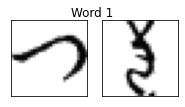

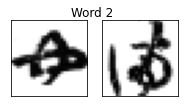

In [15]:
plot_examples(temple_data[0:2], None, row_length=2,title="Word 1")
plot_examples(temple_data[2:], None, row_length=2,title="Word 2")

Use your best model from question 1.2 to classify these images. Implement a small method `predict_characters` that prints the right classes (e.g. 'tsu')given an array of character. Once you have translated them into modern Japanese, translate them to English and type the two words in the variables `q_4_word_1` and `q_4_word_2`.

Hint: You can use Google Translate if you don't know Japanese. Enter the words in Google Translate without spaces between the characters. There may be multiple meanings for a word, you can pick the one that fits the sentence best.

In [16]:
# Implement. Do not change the name or signature of this function.
def predict_characters(X, y, X_test):
    """ Print the class names for all the images in X.
    X -- the data for training and testing
    y -- the correct labels
    X_test -- the new input images as 1D arrays
    """
    pass

predict_characters(X, y, temple_data)

# Fill in the correct meaning
q_4_word_1 = "??"
q_4_word_2 = "??"

print("The sentence is : {} looks beautiful over the {}.".format(q_4_word_1,q_4_word_2))

The sentence is : ?? looks beautiful over the ??.


## Question 5: Bonus question

### Question 5.1 : HOG features (1 point)
Until now, we only used the pixel representation. There are may other ways of feature representation that work much better. One of these is the histogram of oriented gradients (HOG), which counts the occurrences of gradient orientations in localized portions of an image. You can read more about HOG feature descriptors [here](https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f).

Using the **scikit-image** implementation, compute the hog features of an image containing the *tsu* character. You can have a look at this [tutorial](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html). Implement a method `plot_hog_feature` showing an original image and its hog representation side by side. Play with different cell sizes to get a visually better representation. Finally, implement a method `plot_hog_features` that plots multiple cell sizes at once.

This question is deliberative more free-from. You can make your own decisions as long as you adhere to the general method signatures and produce the right output.

In [17]:
def plot_hog_feature(original_image, hog_image, cell_size = 2):
  pass

def plot_hog_features(X,y):
  pass

plot_hog_features(X,y)

## Question 5.2 : A better model? (1 point)

Compute the HOG features for all images in the dataset and train a Logistic Regression model based on the computed features. Explore different cell sizes, and different levels of regularization, to improve your evaluation accuracy while reducing the number of features for each image. Implement a method `compute_hog_feats` that computes all the HOG features, and a method `evaluate_hog_lr` that evaluates the resulting Logistic Regression model and prints out the test set accuracy. You can use a single holdout in this case. Is this model better than the one you found in question 1.2?

In [18]:
def compute_hog_feats(X_original, cell_size):
  pass

def evaluate_hog_lr(X,y):
  pass

# Don't forget to explore different cell sizes for HOG
# compute_hog_feats should be called multiple times
# Don't forget to tune the LogisticRegression hyperparameters. This can be done 
# offline, don't tune them inside evaluate_hog_lr.